In [2]:

# Training pre-trained models using Stratified k-fold method

# Dataset original image size : 256 x 256 pixels
# Resize to 128x128
# k-folds = 3

# Trained  8000 healthy images and approx. 6500 3+ subtypes hemorrhages images with inceptionresnetV2 and inceptionV3 pretrained models
# Trained 10000 healthy images and 10000 2+ subtypes hemorrhages images with inceptionV3 model

# Results: (model filenames in brackets)

# Images with 3+ subtypes (approx. 6500) and 8000 healthy images

# Model 1: Inceptionresnet (inceptionres_modelb), kfolds =2, batch_size=32 : train acc: 98.69% val acc: 94.85% test acc: 90.79%
# Model 2: Inceptionresnet (inceptionres_modelc), kfolds = 3, batch_size =20: train acc: 99.89% val acc: 98.83% test acc: 92.85%
# Model 3: Inceptionv3 (inceptionv3c), kfolds = 3, batch_size =20: train acc: 99.27% val acc: 97.98% test acc: 89.90%

# Images with 2+ subtypes (10000) and healthy images (10000) randomly sampled

# Model 1: Inceptionv3 (inceptionv3d), k folds = 3, batch size = 20: train acc: 99.74% val acc: 97.25% test acc: 85.60%

# Images with 1+ subtypes or any=1 (10000) and healthy images (10000) randomly sampled

# Model 1 : stopped after 2 kfolds due to poor accuracy

In [1]:
#Load libraries

#Data management, analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
#from tqdm import tqdm
from platform import python_version

#Train-test split
from sklearn.model_selection import train_test_split # split data into train and test sets

#Image manipulation
from skimage.io import imread_collection
import skimage.io
import skimage.color
import skimage.transform
from PIL import Image

#Import Keras libraries and packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing import image
#from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import RMSprop

#import k-folds package
from sklearn.model_selection import KFold, StratifiedKFold



In [ ]:
print(tf.__version__)
print(python_version())

2.7.0
3.9.7


**Loading and Pre-processing Data**

In [1]:
#Please skip to 'Extract filenames...' cell if not using google colab

In [2]:
#If using google colab and accessing kaggle dataset
#To get dataset from kaggle to use in google colab, refer to this blog, https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

#from google.colab import files
#files.upload() #upload kaggle.json


In [3]:
#Setting up and installing kaggle library

#!pip install --upgrade --force-reinstall --no-deps kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Download the dataset from kaggle
#https://www.kaggle.com/jhoward/rsna-hemorrhage-jpg

#! kaggle datasets download jhoward/rsna-hemorrhage-jpg

In [5]:
#Extract the files 

#!unzip rsna-hemorrhage-jpg.zip

In [2]:
#Extract filenames from the folder of images

filenames = []
for root, dirs, files in os.walk('archive/train_jpg/train_jpg'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)

In [4]:
len(filenames)

194082

In [5]:
#Load the labels file
labels = pd.read_feather('archive/meta/meta/labels.fth')



In [6]:
#Go through filename list to remove the .jpg at the end
idstosearch = [item.rstrip(".jpg") for item in filenames]

#Search the "ID" column for IDs that correspond to the filenames
labels = labels[labels['ID'].isin(idstosearch)]

In [7]:
#Obtain dataset with only images with 3+ hemorrhages types and healthy images that are randomized

random.seed(10)
images_hem = labels[labels[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) >= 3].copy()
#images_hem = labels[labels['any'] == 1].copy() #same as 1+ hemorrhages
#images_hem= images_hem.sample(n = 10000) #for use with 1+ (or any = 1) or 2+ hemorrhages
images_healthy = labels[labels['any'] == 0].copy()
images_healthy = images_healthy.sample(n = 10000)
frames = [images_healthy, images_hem]
images_data = pd.concat(frames)
images_data = images_data.sort_values('ID')
print("Number of images with hemorrhage: "+"{}".format(len(images_hem)))
print("Number of healthy images: "+"{}".format(len(images_healthy)))
print("Percent of dataset with hemorrhage: "+"{:.2%}".format(len(images_hem)/len(images_data)))

Number of images with hemorrhage: 10000
Number of healthy images: 10000
Percent of dataset with hemorrhage: 50.00%


In [12]:
#Splitting dataset into train and test sets at 90% and 10% respectively. Test set used for evaluating model after training

train_data, test_data = train_test_split(images_data,test_size= 0.1)


In [13]:
#Split labels to train and test
labels_train = train_data.iloc[:,1]
labels_test = test_data.iloc[:,1]


In [14]:
#Function to import the selected images 

def import_images(images_data):
    imagelist = images_data['ID']
    images = ["archive/train_jpg/train_jpg/"+ x + ".jpg" for x in imagelist]
    return images
   

In [11]:
#Import selected train and test images

train_images = import_images(train_data)
test_images = import_images(test_data)

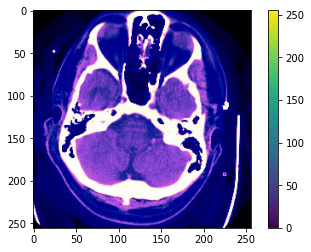

In [12]:
# Visualize the first image
train_coll = imread_collection(train_images)

plt.figure()
plt.imshow(train_coll[0])
plt.colorbar()
plt.grid(False)
plt.show()

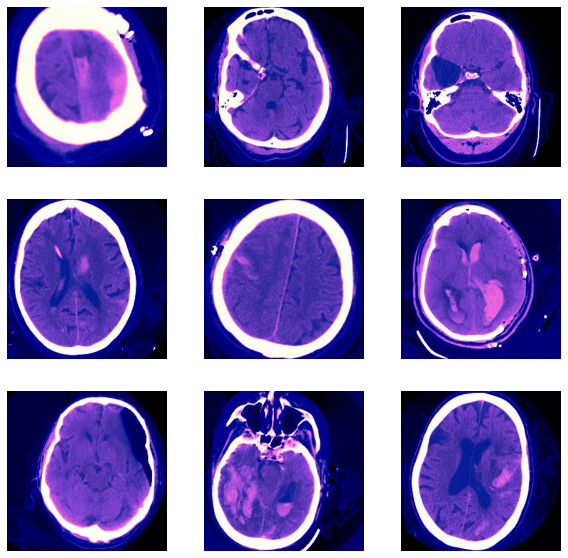

In [ ]:
#Visualize the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(train_coll[i])
    plt.axis("off")

In [15]:
#Function to resize image and add to array if choosing to resize

def convert_img(img):
    #img - image file
    #resizes image to specific size
    #adds image to list
    new = image.load_img(img, target_size = (128,128))
    new = image.img_to_array(new)
    return new

In [16]:
#If resizing images, resize with above function and convert to numpy array. 

train =np.array([convert_img(img)
                    for img in train_images])

test =np.array([convert_img(img)
                    for img in test_images])

In [ ]:
#Only run this cell if not wanting to resize images

#train = np.array(train_coll)
#test_coll = imread_collection(test_images)
#test = np.array(test_coll)

In [17]:
print(train.shape)
print(test.shape)

(18000, 128, 128, 3)
(2000, 128, 128, 3)


In [18]:
#Convert labels to array

labels_train = pd.Series.to_numpy(labels_train)
labels_test = pd.Series.to_numpy(labels_test)


print(labels_train.shape)
print(labels_test.shape)

(18000,)
(2000,)


In [ ]:
#Convolution Neural Network (Deep-CNN)
#def getCNNmodel():

#    model = Sequential()
#    model.add(Conv2D(32, kernel_size=(5, 5), 
#                    activation='relu', input_shape=(256, 256, 3)))
 #   model.add(MaxPooling2D(pool_size=(2, 2)))
  #  model.add(Dropout(0.25))
 #   model.add(Conv2D(64, (5, 5), activation='relu'))
 #   model.add(MaxPooling2D(pool_size=(2, 2)))
  #  model.add(Dropout(0.25))
  #  model.add(Flatten())
 #   model.add(Dense(1024, activation='relu'))
 #   model.add(Dense(1, activation='sigmoid'))
 #   model.summary()
 #   model.compile(loss='binary_crossentropy',
 #             optimizer=RMSprop(learning_rate=0.0001),
  #            metrics=['acc']) 
    #return model
    


In [19]:
#Import the pre-trained models
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg19 import VGG19
#from keras.applications.resnet import ResNet50

In [21]:
#Get Pre-trained model

def getModel(pretrained):
    model = pretrained(include_top=False, input_shape=(128,128,3),weights='imagenet')
    #Make model not trainable for use in feature extraction
    for layer in model.layers:
        layer.trainable = False
    #Get last layer
    last_output = model.layers[-1].output
    # Flatten the output layer to 1 dimension
    res = Flatten()(last_output)
    # Add a fully connected layer with 1,024 hidden units and ReLU activation
    res = Dense(1024, activation='relu')(res)
   # Add a dropout rate of 0.2
    #res = Dropout(0.2)(res)
    # Add a final sigmoid layer for classification
    res = Dense(1, activation='sigmoid')(res)

    # Configure and compile the model
    model = Model(model.input, res)
    model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=0.0001),
                metrics=['acc'])
    model.summary()
    return model
    

In [22]:
#Get model 
#CNN_model = getCNNmodel()
model = getModel(InceptionV3)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [23]:
#Normalize the images by dividing each pixel by 255

train_datagen = ImageDataGenerator(rescale = 1./255
                                        )
val_datagen = ImageDataGenerator(rescale = 1./255
                                        )

test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
#stratified k fold cross validation


skf = StratifiedKFold(n_splits = 3, random_state = 7, shuffle = True) 

fold = 0

X= train
Y= labels_train

for train_index, val_index in skf.split(X,Y):
    fold += 1
    print("Results for fold",fold)
    
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]
    

    #Start Image classification model
    train_generator = train_datagen.flow(X_train, Y_train, batch_size=20)

    validation_generator = val_datagen.flow(X_val, Y_val, batch_size= 20)

   
    #Fit the model
    history = model.fit(train_generator,epochs = 10, validation_data = validation_generator, verbose =1)


    #Evaluate metrics
    #predictions = inception_model.predict(validation_generator, verbose=1)
    #yPredictions = np.argmax(predictions, axis=1)
    #true_classes = validation_generator.classes
    # evaluate validation performance
    #print("***Performance on Validation data***")    
    #valAcc, valPrec, valFScore = get_Metrics(true_classes, yPredictions)

   
  

Results for fold 1
Epoch 1/10
600/600 [==============================] - 234s 386ms/step - loss: 0.8968 - acc: 0.4988 - val_loss: 0.7084 - val_acc: 0.4985
Epoch 2/10
600/600 [==============================] - 225s 374ms/step - loss: 0.7029 - acc: 0.5151 - val_loss: 0.7059 - val_acc: 0.5007
Epoch 3/10
600/600 [==============================] - 226s 377ms/step - loss: 0.6989 - acc: 0.5271 - val_loss: 0.7016 - val_acc: 0.5128
Epoch 4/10
600/600 [==============================] - 272s 454ms/step - loss: 0.6928 - acc: 0.5475 - val_loss: 0.7121 - val_acc: 0.5117
Epoch 5/10
600/600 [==============================] - 360s 600ms/step - loss: 0.6828 - acc: 0.5628 - val_loss: 0.7253 - val_acc: 0.5092
Epoch 6/10
600/600 [==============================] - 357s 596ms/step - loss: 0.6729 - acc: 0.5810 - val_loss: 0.7246 - val_acc: 0.5123
Epoch 7/10
600/600 [==============================] - 364s 608ms/step - loss: 0.6610 - acc: 0.6003 - val_loss: 0.7316 - val_acc: 0.5105
Epoch 8/10
600/600 [=========

In [52]:
#Save model


saved_model = model
inc_model = 'inceptionv3e.h5'
saved_model.save(inc_model)


In [23]:
#Use only on google colab

#!zip -r model.zip {inc_model}

  adding: inceptionv3c.h5 (deflated 9%)


In [24]:
#Use only on google colab

#try:
  #from google.colab import files
 # files.download('./model.zip')
#except ImportError:
  #pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
 #Evaluate metrics
 
train_acc =model.evaluate(train_generator, verbose=1)
val_acc = model.evaluate(validation_generator, verbose=1)

300/300 [==============================] - 68s 228ms/step - loss: 0.0791 - acc: 0.9725


In [54]:
#Test the model

test_generator = test_datagen.flow(test, labels_test, batch_size= 20)
predictions = model.predict(test_generator)

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))


100/100 [==============================] - 23s 230ms/step - loss: 0.8133 - acc: 0.8560
Test Accuracy: 85.60%
